In [1]:
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
     
import torch as t
from torch import Tensor, nn , optim
from torch.utils.data import DataLoader
from transformer_lens.utils import to_numpy
import plotly.express as px
from tqdm.notebook import tqdm
from dataclasses import dataclass
import pprint
import plotly.express as px
import einops
from jax import numpy as jnp
import matplotlib.pyplot as plt
from torch_sgld import SGLD


import importlib
from copy import deepcopy

def reload_fuctions():
    '''
    Reloads the functions from the utils package. 
    This is useful when you are working on the functions 
    and want to see the changes without restarting the kernel.'''
    import utils

    importlib.reload(utils.data)
    importlib.reload(utils.model)
    importlib.reload(utils.plotting)

    globals().update({name: getattr(utils.data, name) for name in dir(utils.data)})
    globals().update({name: getattr(utils.model, name) for name in dir(utils.model)})
    globals().update({name: getattr(utils.plotting, name) for name in dir(utils.plotting)})

    

from utils.data import *
from utils.model import *
from utils.plotting import *

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

/home/amir/.conda/envs/arena/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/amir/.conda/envs/arena/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/amir/.conda/envs/arena/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Tracr sorting model
It translates the inputs into unique keys and sort them using unique sort. which is implemented like this:
```python

```

In [162]:
make_sort = 0
input_size = 10
vocab = {*range(input_size*2)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=input_size,
      compiler_bos="bos",
      mlp_exactness=100)

INPUT_ENCODER = assembled_model.input_encoder
OUTPUT_ENCODER = assembled_model.output_encoder


In [181]:
x = ["bos"] + [np.random.randint(0,20) for _ in range(10)]
print(assembled_model.apply(x).decoded[1:])
print(sorted(x[1:]))

[5, 7, 9, 10, 13, 14, 15, 16, 17, 17]
[5, 7, 9, 10, 13, 14, 15, 16, 16, 17]


## Tracr model Config
After compling we see that the model has 2 layers, which is less that the maximum sequence length, meaning that the model is able to sort sequences longer than it's model length

In [118]:
pprint.pprint(assembled_model.model_config)

TransformerConfig(num_heads=1,
                  num_layers=3,
                  key_size=12,
                  mlp_hidden_size=100,
                  dropout_rate=0.0,
                  activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x7fe600519990>,
                  layer_norm=False,
                  causal=False)


In [72]:
reload_fuctions()
TRAIN = True 

cfg = cfg_from_tracr(assembled_model)
model = HookedTransformer(cfg)
model_mid_decay = deepcopy(model)
model_high_decay = deepcopy(model)
tr_model = HookedTransformer(cfg)
tr_model = load_tracr_weights(tr_model, assembled_model, cfg)

criterion = nn.CrossEntropyLoss()
losses = []
decays = [0, 0.001, 0.01]

if TRAIN:
    epochs = 300
    batch_size = 4096
    for lamb,m in zip(decays, [model, model_mid_decay, model_high_decay]):
        optimizer = t.optim.AdamW(m.parameters(), lr=0.001)
        
        
        save_path = f'models/sort_mini_{lamb}_l1_activation.pth' 

        losses.append(train_model(m, optimizer, criterion, l1_pentaly_activation(lamb), train_loader, epochs, batch_size, input_size, len(vocab), save_path))
        

save_paths = [f'models/sort_mini_{decay}_l1_activation.pth' for decay in decays]

for m, save_path in zip([model, model_mid_decay, model_high_decay], save_paths):
    print(save_path)
    m.load_state_dict(t.load(save_path), strict=False)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [07:10<00:00,  1.44s/it]

models/sort_mini_0_l1_activation.pth
models/sort_mini_0.001_l1_activation.pth
models/sort_mini_0.01_l1_activation.pth


In [74]:
import pandas as pd


if True:
    df = pd.DataFrame()
    for idx, loss in enumerate(losses):
        df = pd.concat([df, pd.DataFrame(
            {'Epoch': range(len(loss)), 
            'Loss': loss, 
            'Model': f'Model {decays[idx]}'}
            )])

    df.to_csv('sort_mini_activation.csv')
else:
    df = pd.read_csv('sort_mini.csv')

fig = px.line(df, x='Epoch', y='Loss', color='Model', title='Loss over time', log_y=True)
fig.show()


In [62]:
TRAIN_COMPRESSED = True
reload_fuctions()
compressed_model = deepcopy(model)
compressed_model.compression = CompressionHook(model.cfg.d_model, 1.3)
pre_training_weight = compressed_model.compression.fc_compress.weight.clone()
losses = []

if TRAIN_COMPRESSED:
    epochs = 300
    batch_size = 4096*2
    optimizer = optim.SGD( 
        [{'params': compressed_model.compression.parameters(), 'lr': 0.001}])  # Parameters from the rest of the model
    save_path = f'models/sort_mini_compessed.pth' 

    losses.extend(train_model(compressed_model, optimizer, criterion, l1_pentaly(0.01), train_loader, epochs, batch_size, input_size, len(vocab), save_path))

post_training_weight = compressed_model.compression.fc_compress.weight.clone()

  1%|          | 3/300 [00:07<12:12,  2.47s/it]

100%|██████████| 300/300 [12:14<00:00,  2.45s/it]


In [63]:
px.line(losses, title='Loss over time', log_y=True) 

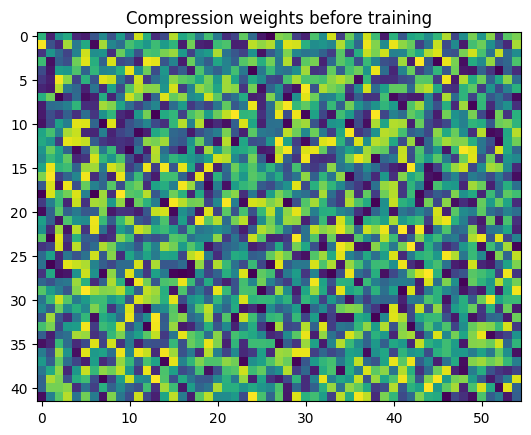

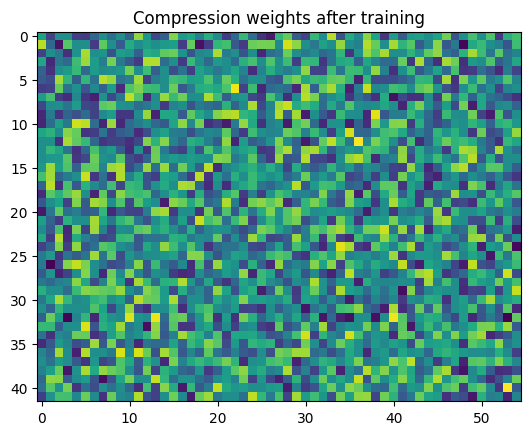

In [67]:
diff_weights = pre_training_weight - post_training_weight
plt.imshow(to_numpy(pre_training_weight))
plt.title("Compression weights before training")
plt.show()
plt.imshow(to_numpy(post_training_weight))
plt.title("Compression weights after training")
plt.show()

I might have lost the data for the original training loss curve

In [116]:
reload_fuctions()

models = [model, model_mid_decay, model_high_decay, compressed_model, assembled_model, tr_model]
model_names = ['Model:\t\t', 'Model 0.01 decay:', 'Model 0.1 decay:','Compressed Model', 'Tracr model:\t', "Tracr model copied"]
input_size = 10
x,y = generate_data(1, len(vocab), input_size)
print('Data in:\t\t', x.squeeze().tolist())
print('Data out:\t\t', y.squeeze().tolist())

for i, mod in enumerate(models):
    pred = prompt(mod, x)
    if model_names[i] == 'Compressed Model':
        continue
    print(f'{model_names[i]}\t', pred)

Data in:		 [8, 7, 8, 2, 9, 1, 4, 2, 6, 4]
Data out:		 [1, 2, 2, 4, 4, 6, 7, 8, 8, 9]
Model:			 [1, 2, 2, 4, 4, 6, 7, 8, 8, 9]
Model 0.01 decay:	 [1, 2, 2, 4, 4, 6, 7, 8, 8, 9]
Model 0.1 decay:	 [1, 2, 2, 4, 4, 6, 7, 8, 8, 9]
Tracr model:		 [1, 2, 2, 4, 2, 6, 7, 8, 2, 9]
Tracr model copied	 [0, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [69]:
reload_fuctions()
assembled_logits, assembled_cache = run_with_activations(assembled_model, x)
trained_logits, trained_cache = run_with_activations(model, x)
trained_mid_decay_logits, trained_mid_decay_cache = run_with_activations(model_mid_decay, x)
trained_high_decay_logits, trained_high_decay_cache = run_with_activations(model_high_decay, x)
tracr_logits, tracr_cache = run_with_activations(tr_model, x, INPUT_ENCODER)
compressed_logits, compressed_cache = run_with_activations(compressed_model, x)

## Tracr Transformer output reference:
| Activation      | Dimension                          |
|-----------------|------------------------------------|
| layer_outputs   | [Batch, Sequence_Size, d_embedding]|
| residuals       | [Batch, Sequence_Size, d_embedding]|
| attn_logits     | [Batch, n_heads, Sequence_Size, Sequence_Size]|
| output          | [Batch, Sequence_Size, d_embedding]|
| input_embeddings| [Batch, Sequence_size, d_embedding]|

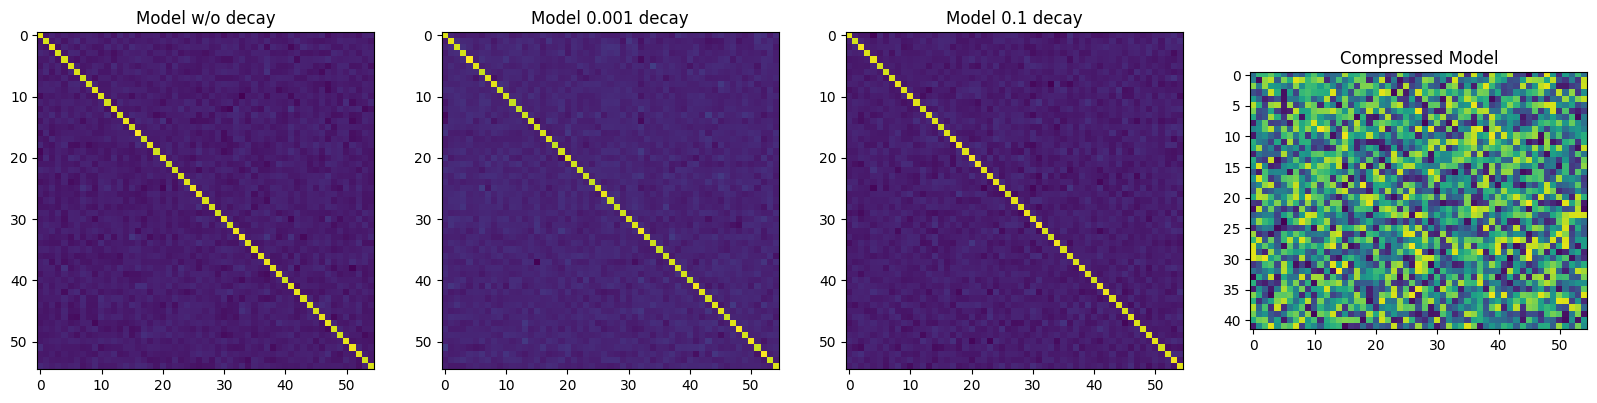

In [11]:
reload_fuctions()
compression_hooks = [m.compression.weight for m in [model, model_mid_decay, model_high_decay, compressed_model]]
compression_hook_names = ['Model w/o decay', 'Model 0.001 decay', 'Model 0.1 decay', 'Compressed Model']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, hook in enumerate(compression_hooks):
    axs[i].imshow(to_numpy(hook))
    axs[i].set_title(compression_hook_names[i])

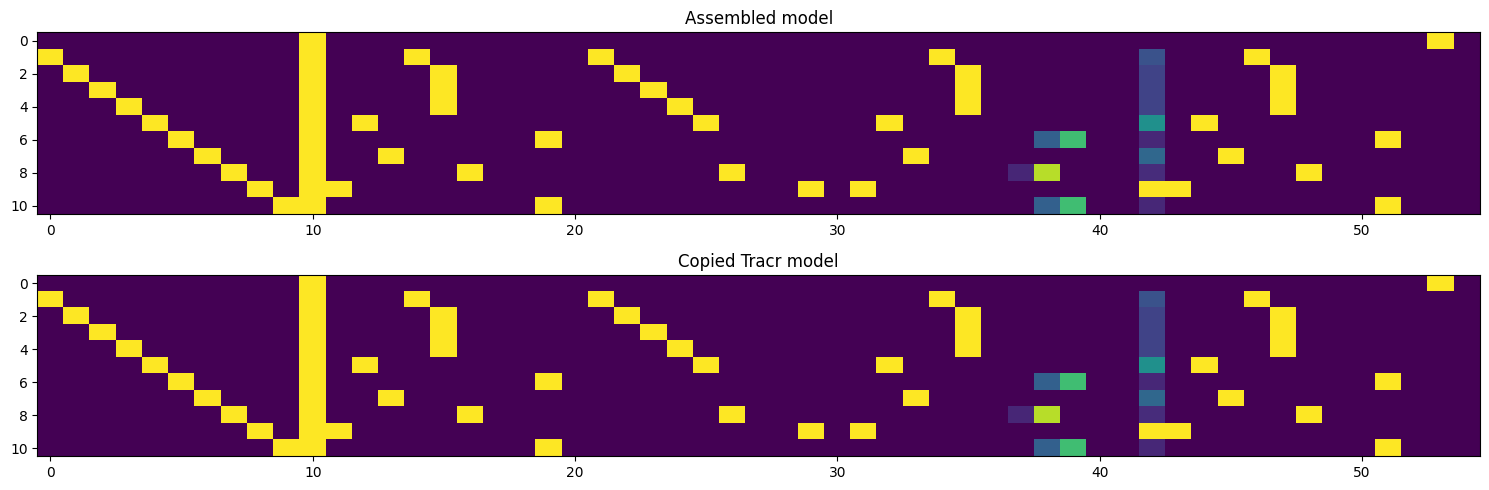

In [67]:
copied_out = to_numpy(tracr_cache['blocks.2.hook_resid_post']).squeeze()
assembled_out = assembled_cache.transformer_output.squeeze()

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].imshow(assembled_out, aspect='auto')
ax[0].set_title('Assembled model')
ax[1].imshow(copied_out, aspect='auto')
ax[1].set_title('Copied Tracr model')
plt.tight_layout()
plt.show()

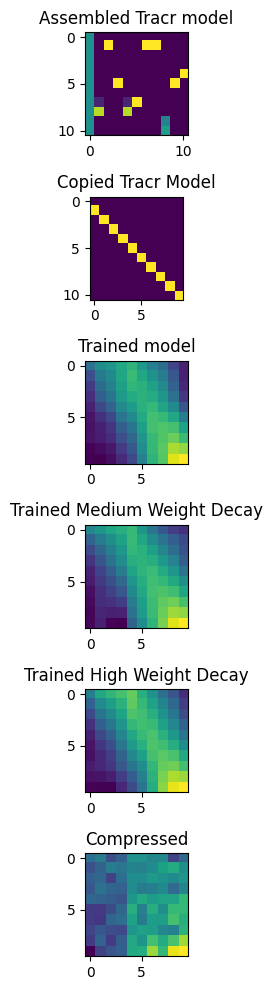

In [12]:
reload_fuctions()
logits = [
    np.array(assembled_logits[-1]),
    to_numpy(tracr_logits),
    to_numpy(trained_logits),
    to_numpy(trained_mid_decay_logits),
    to_numpy(trained_high_decay_logits),
    to_numpy(compressed_logits)
]

plot_activations(["Assembled Tracr model", "Copied Tracr Model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay", "Compressed"], *logits)

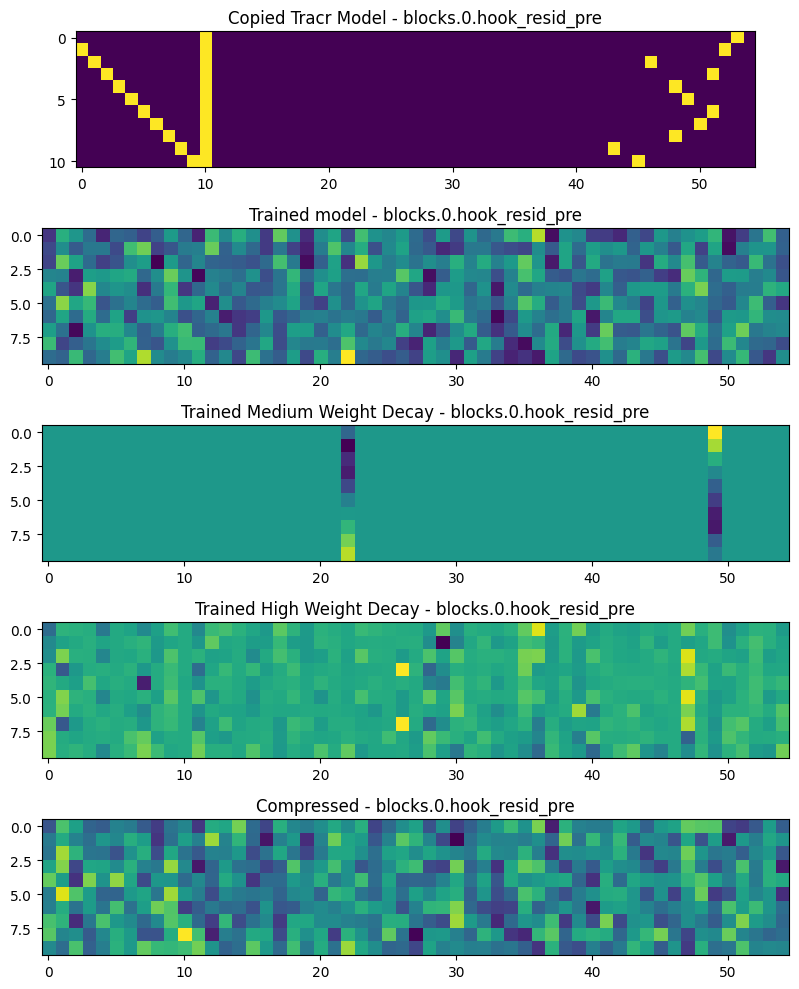

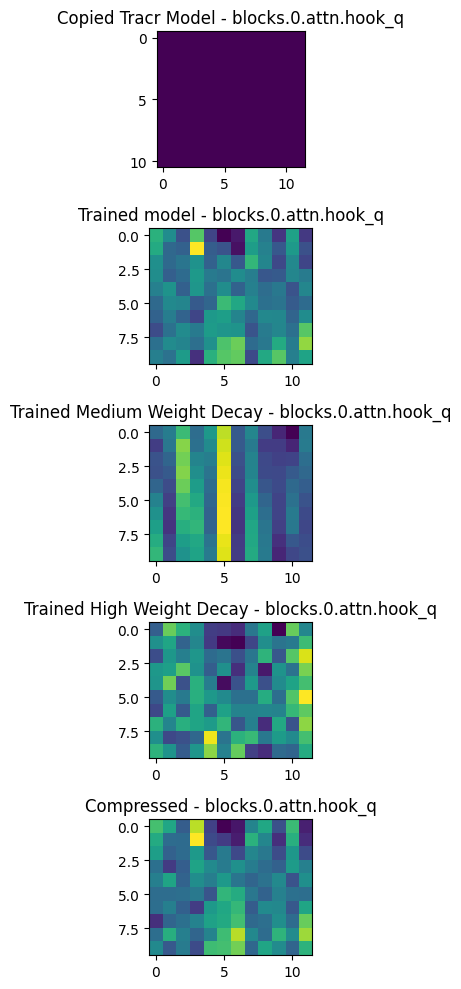

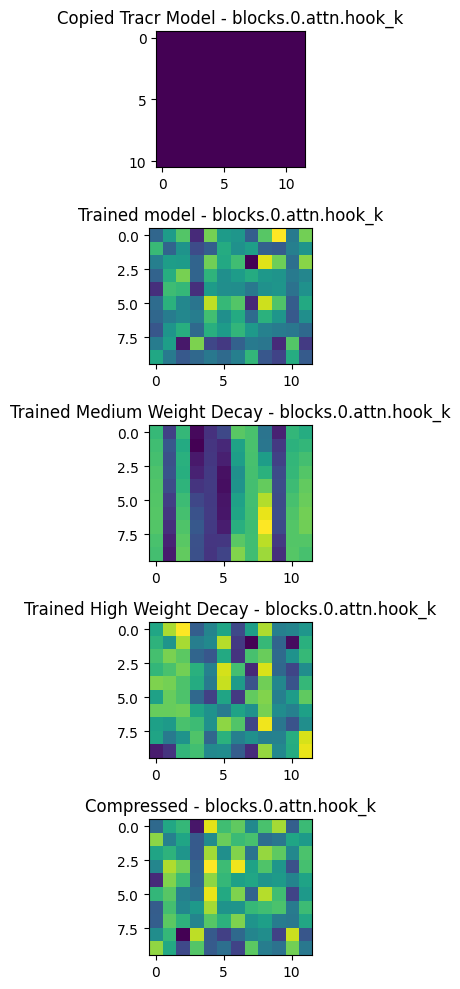

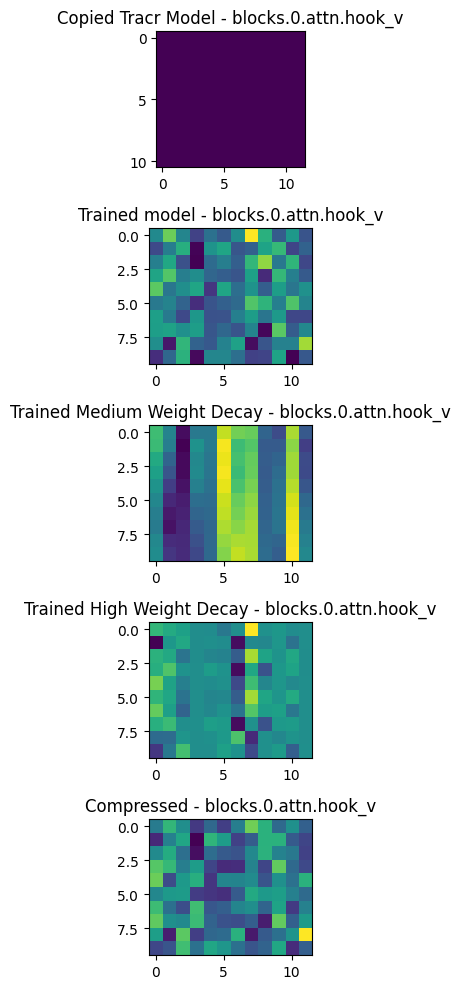

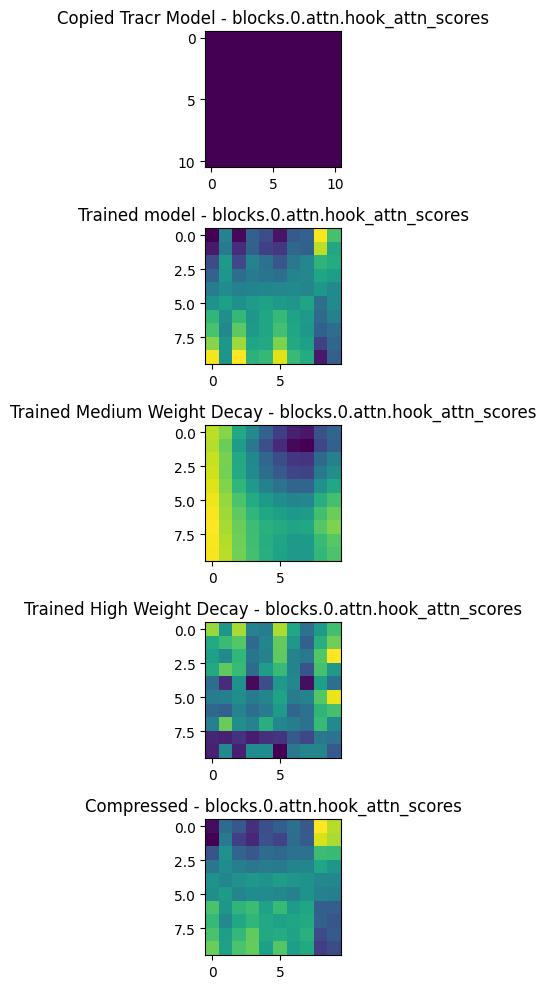

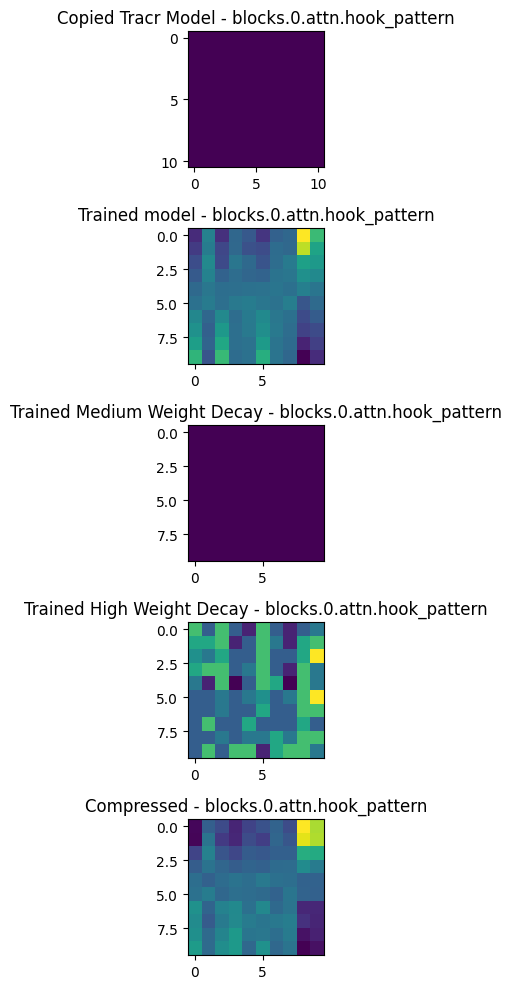

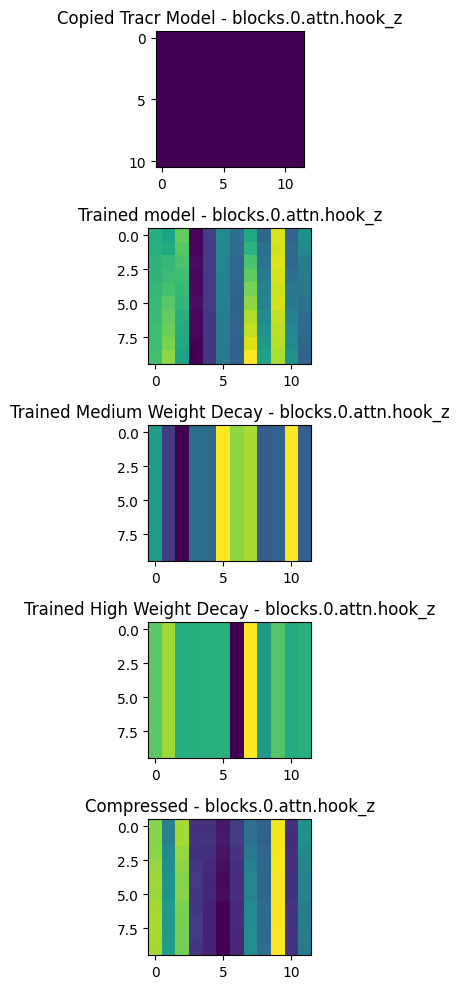

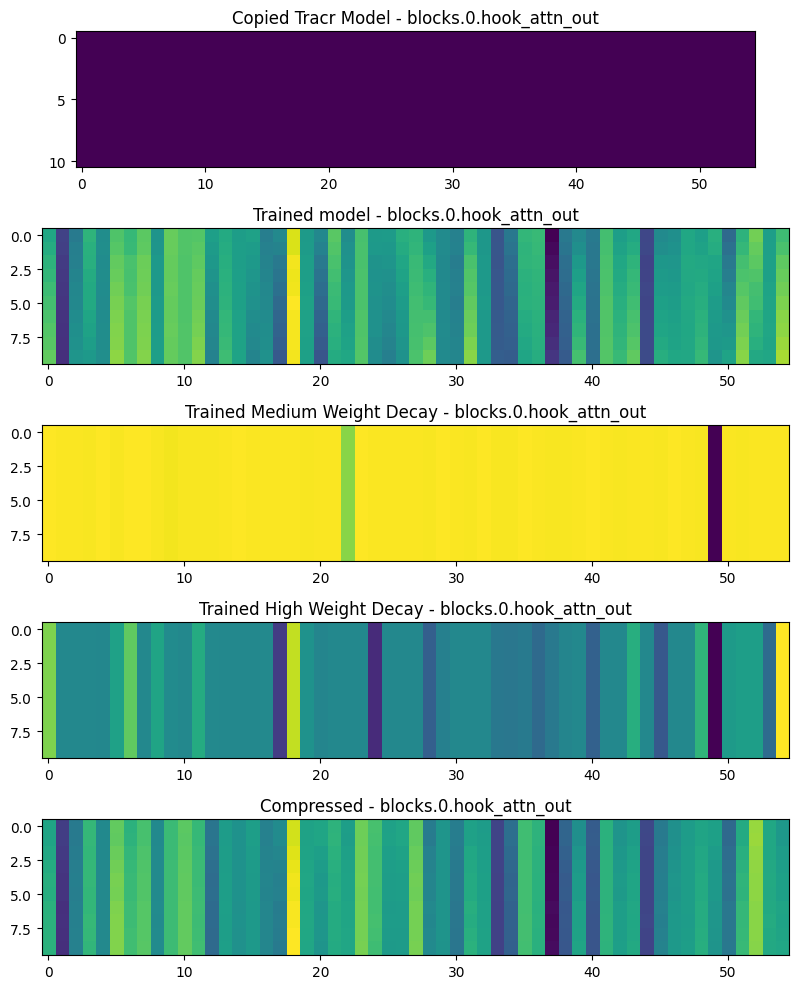

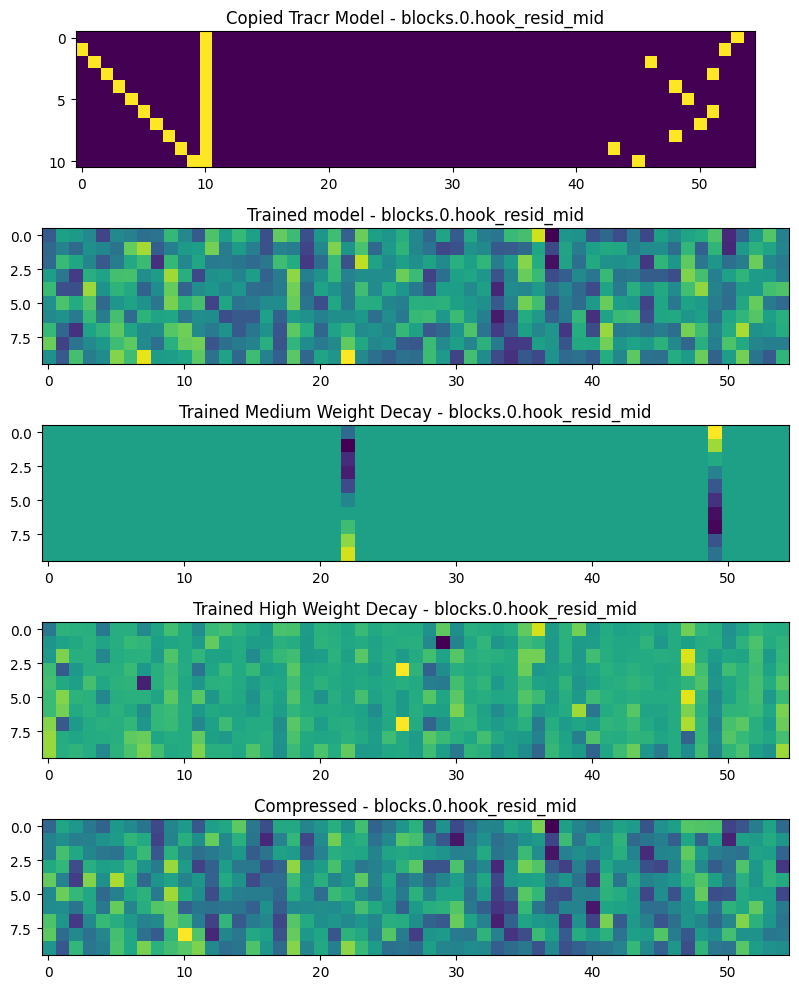

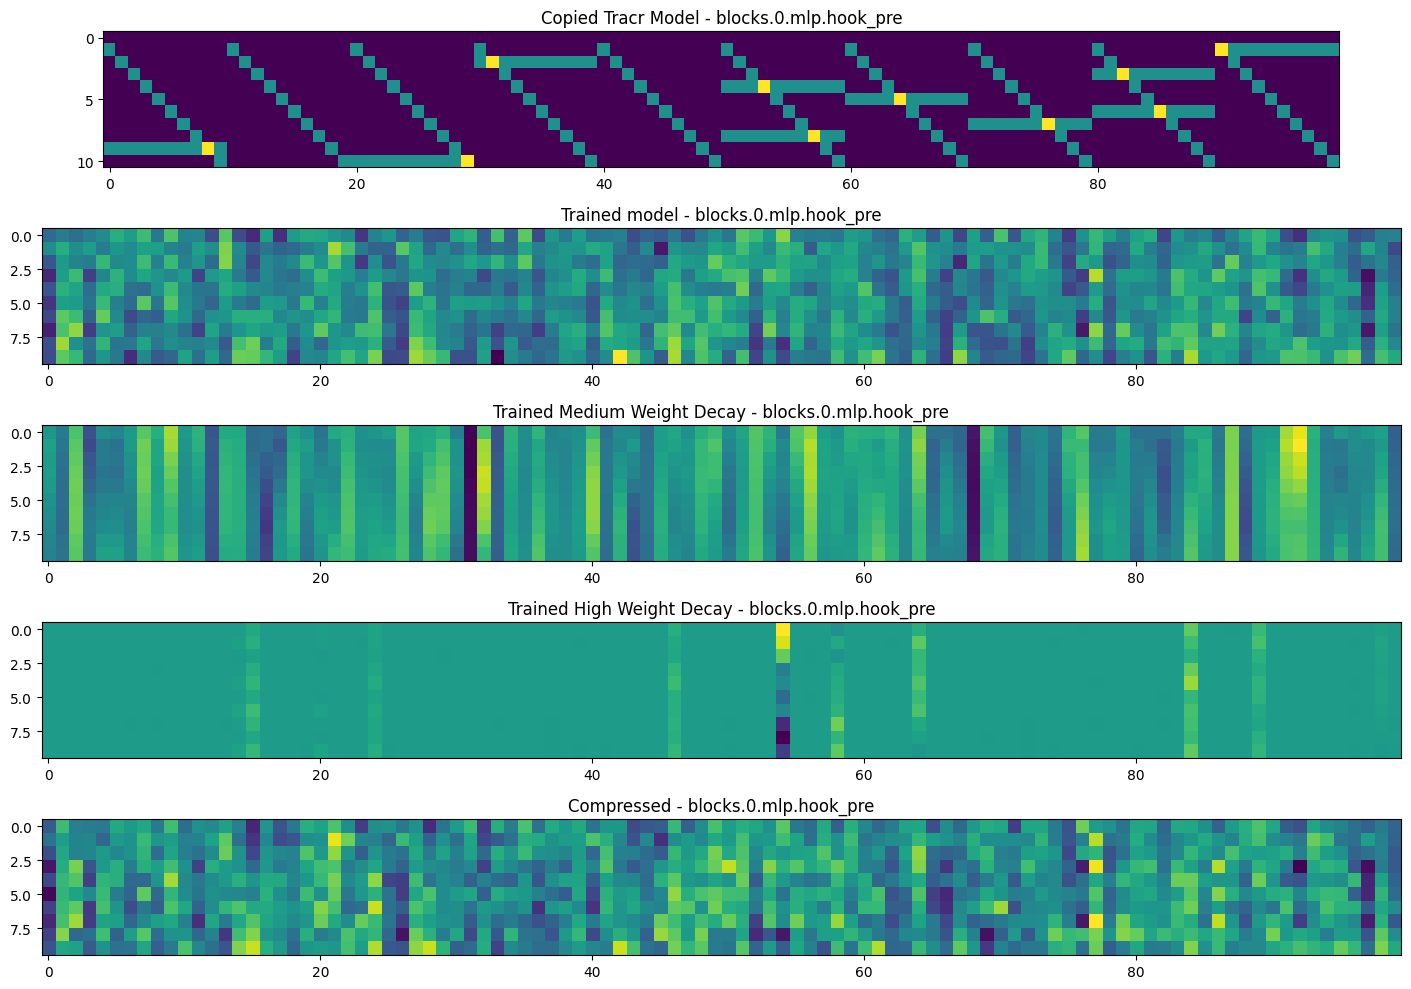

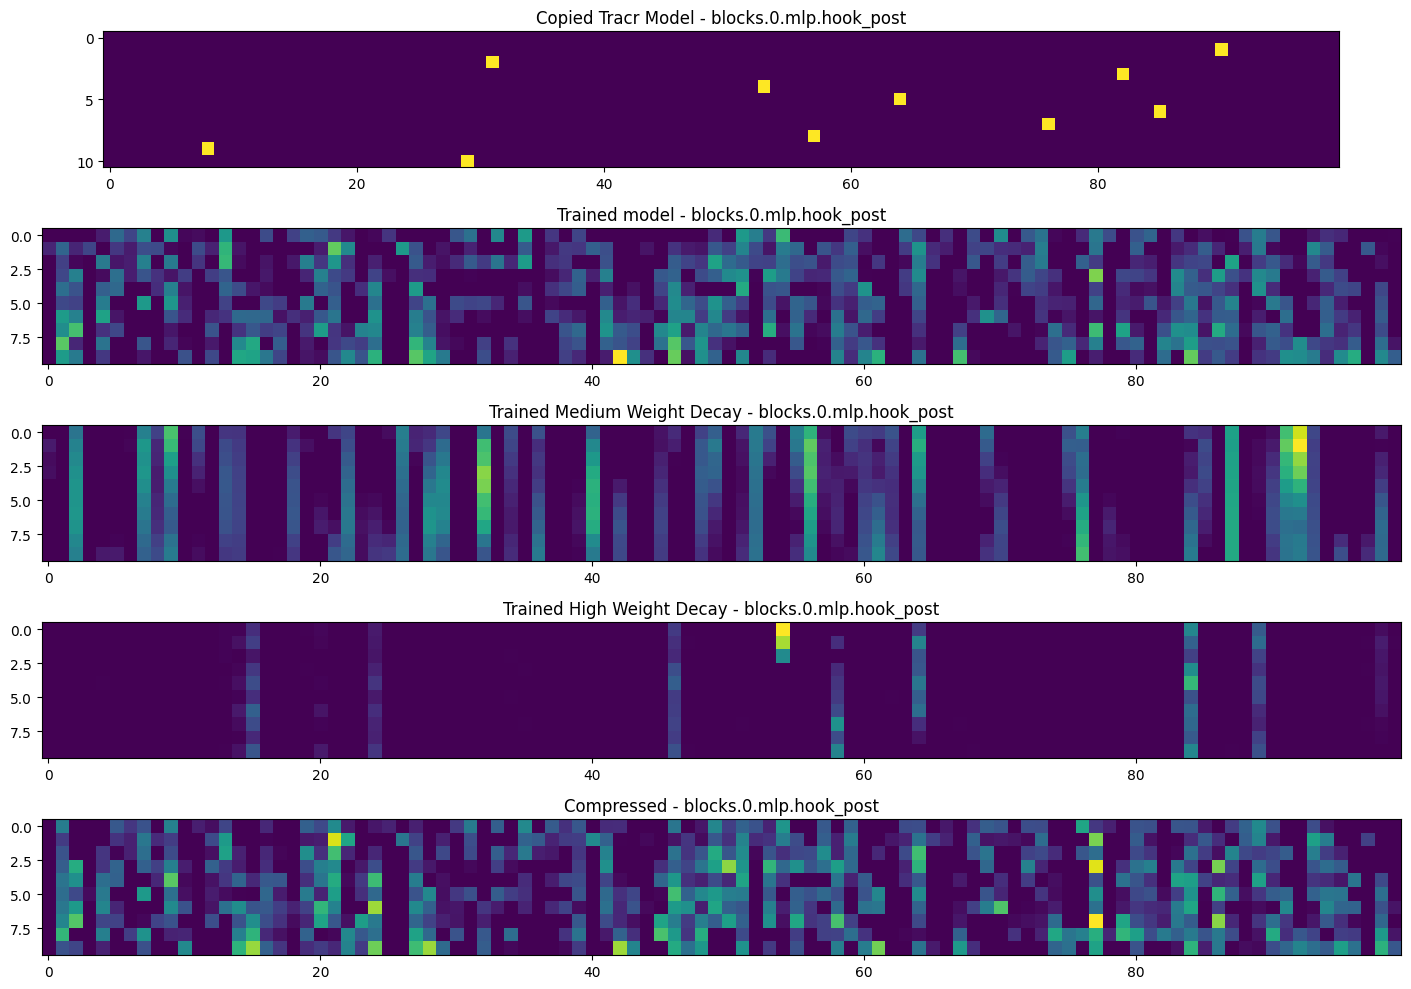

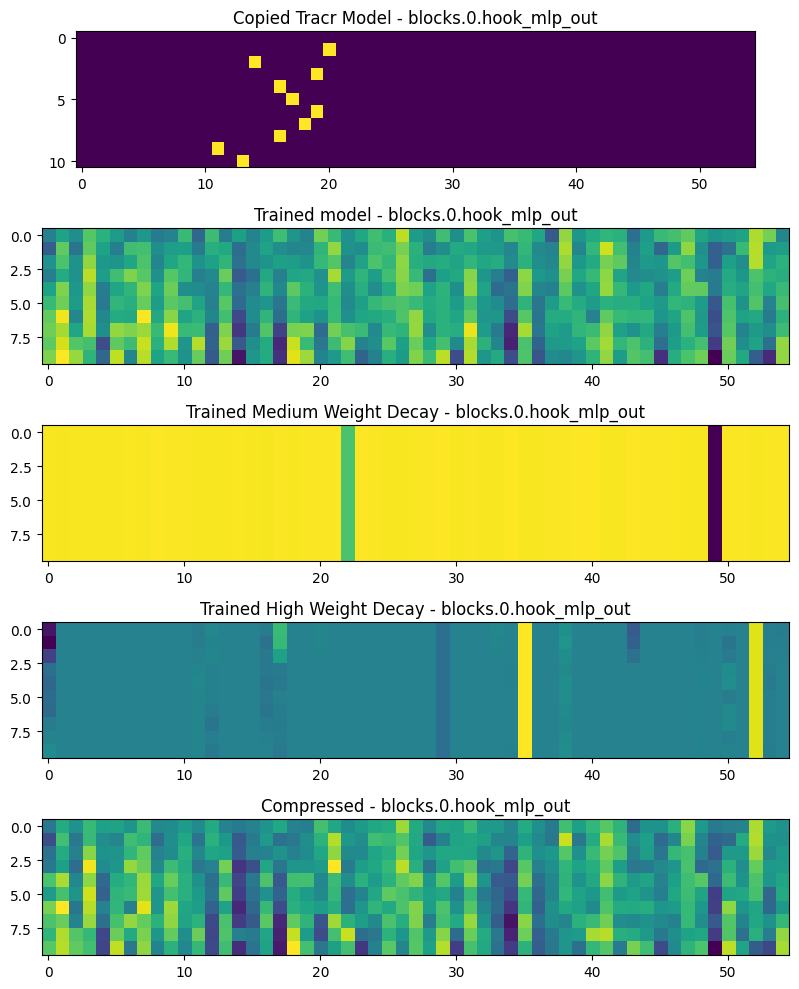

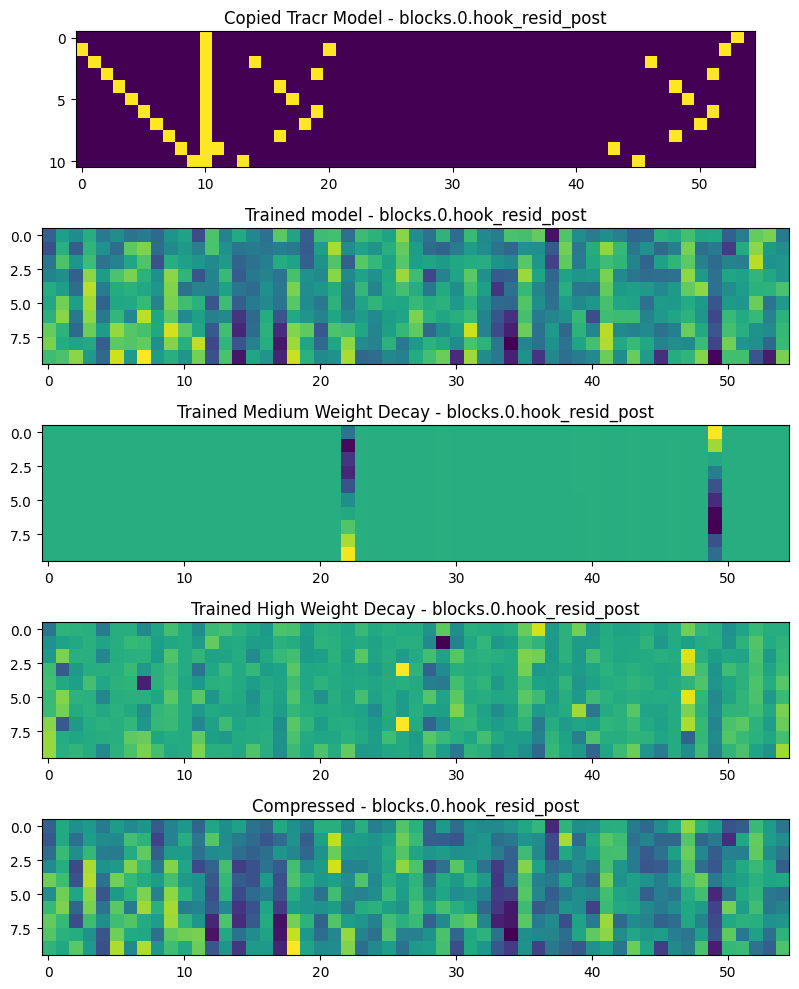

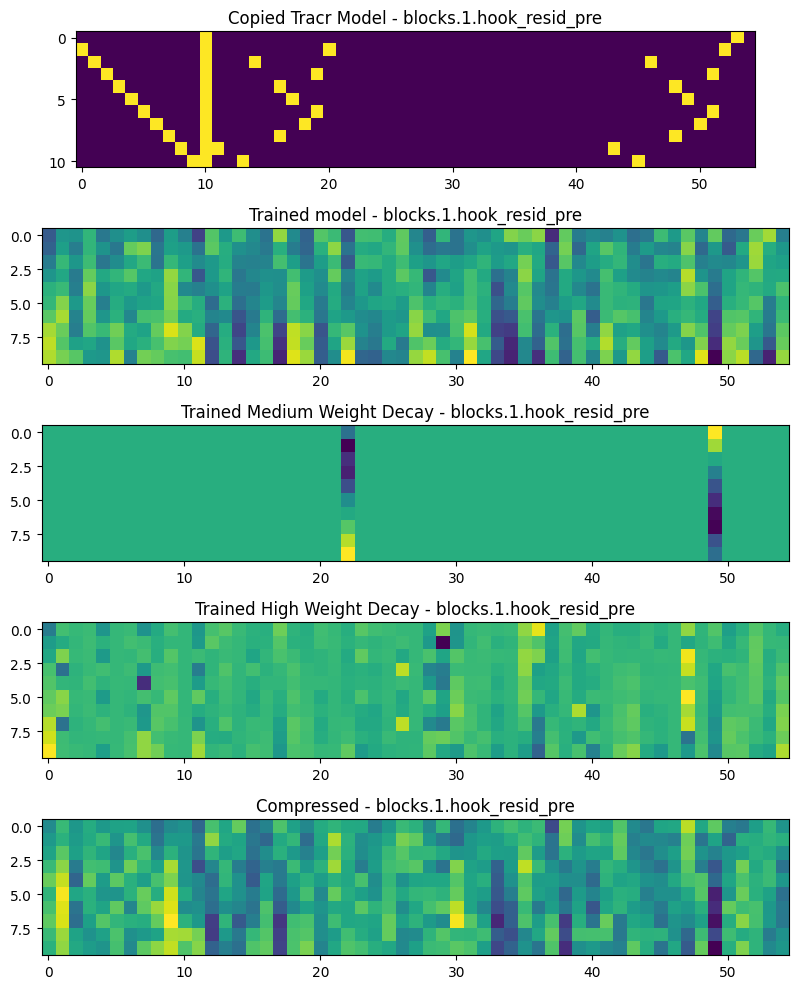

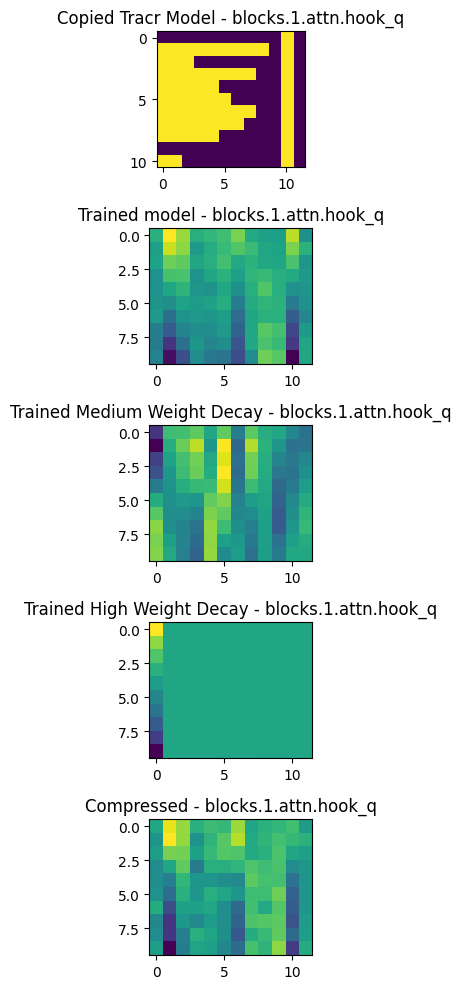

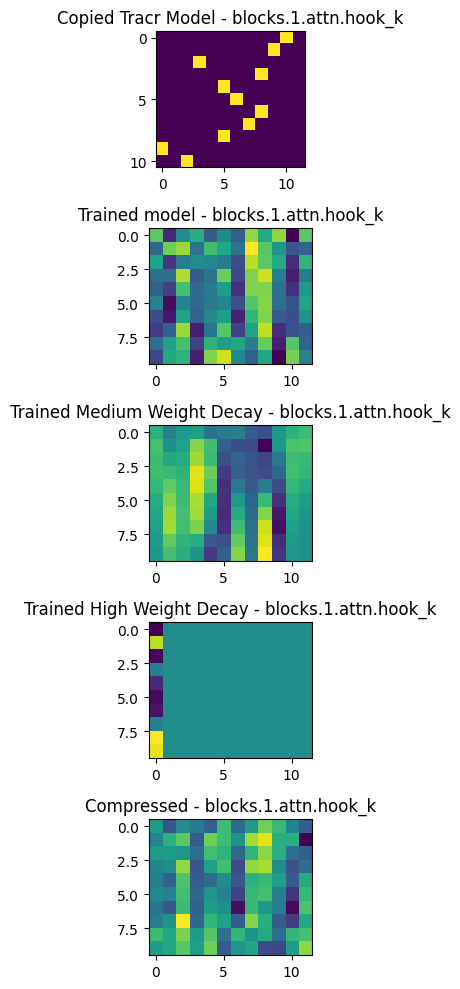

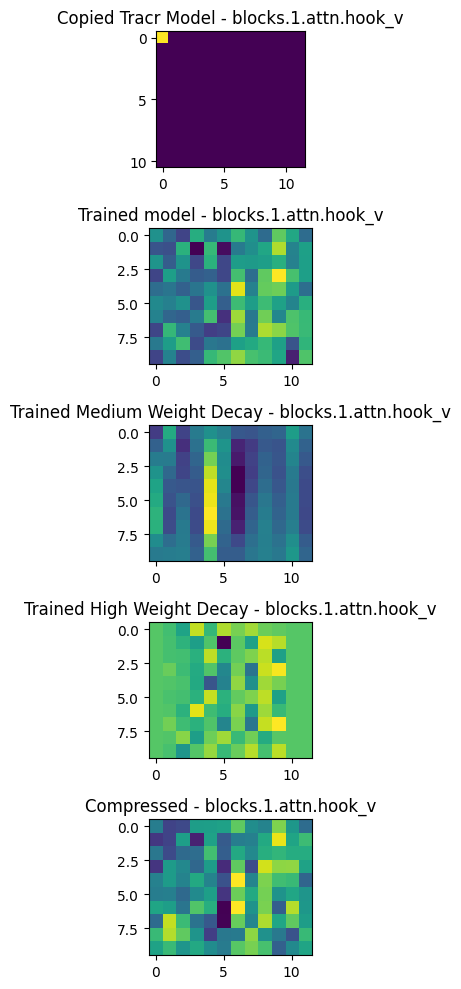

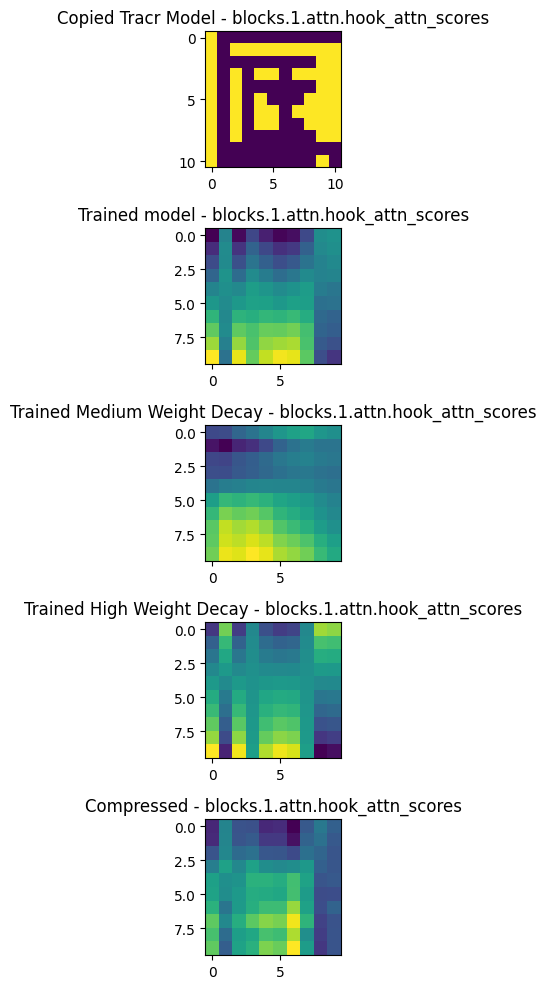

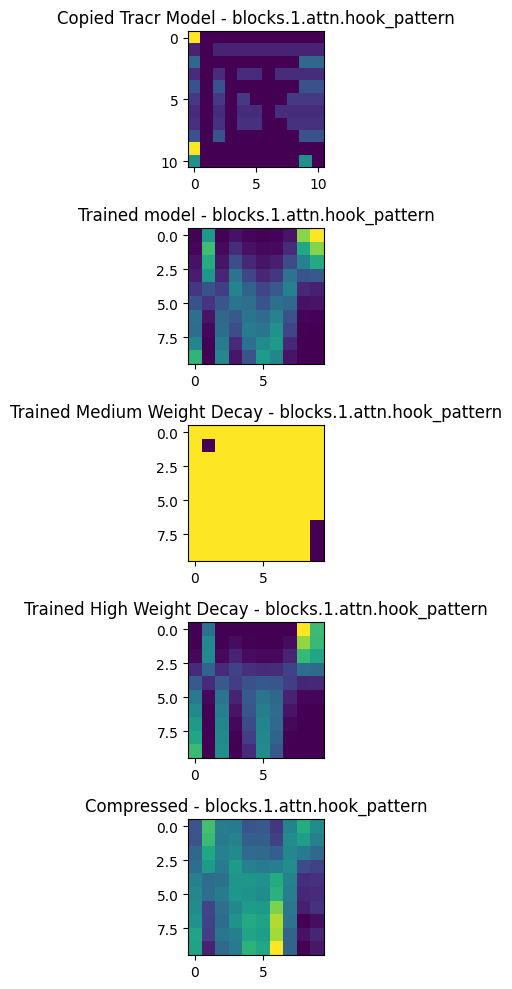

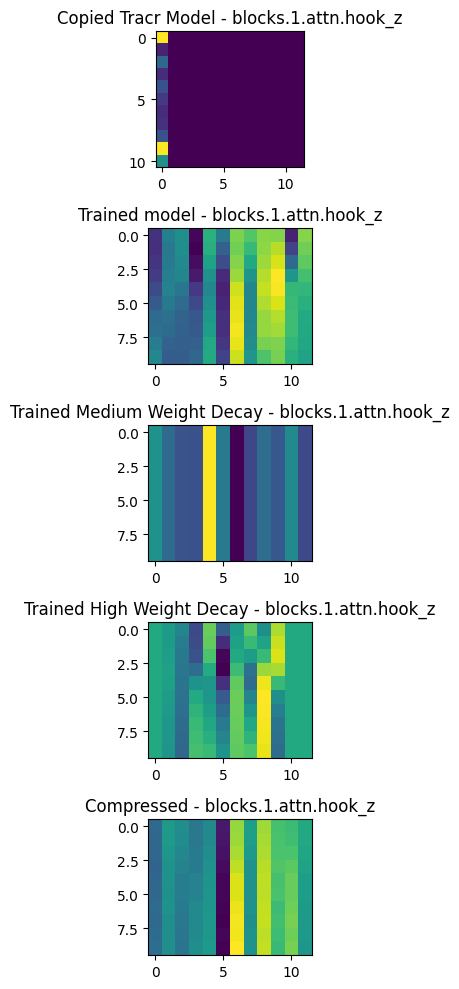

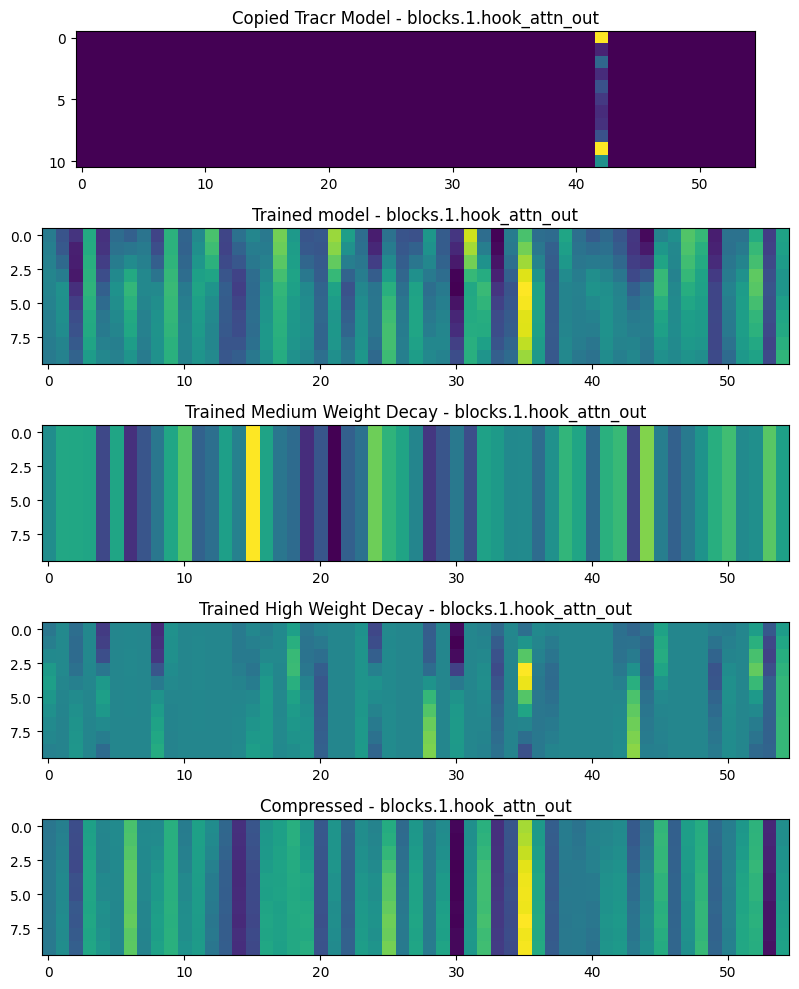

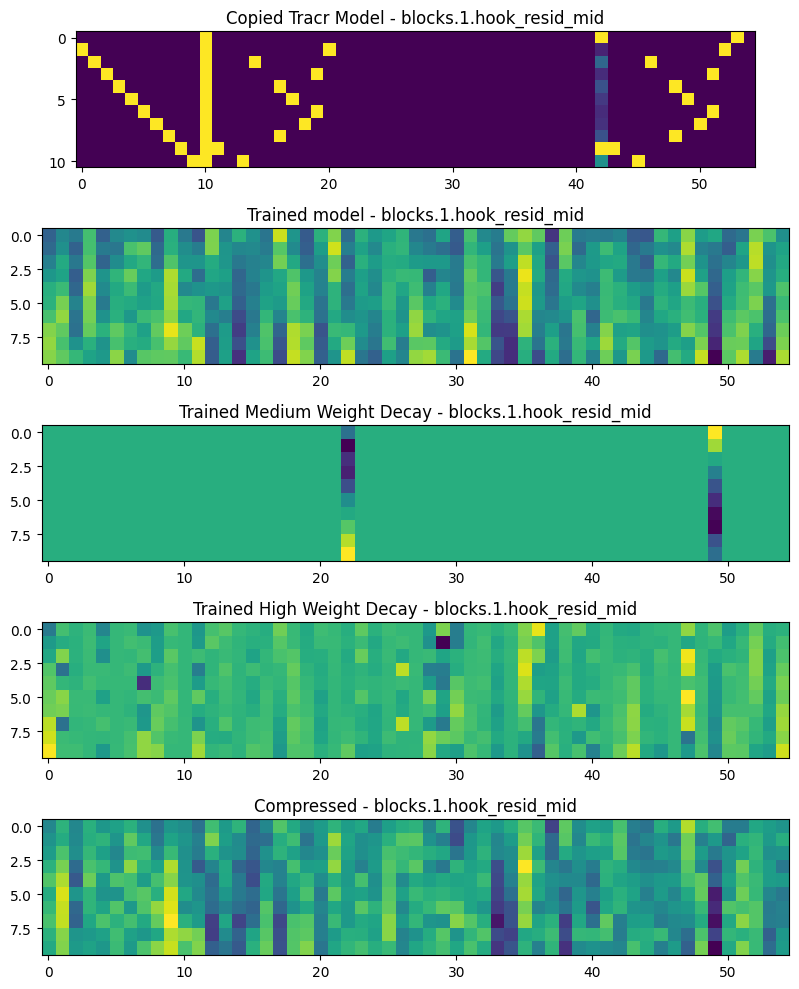

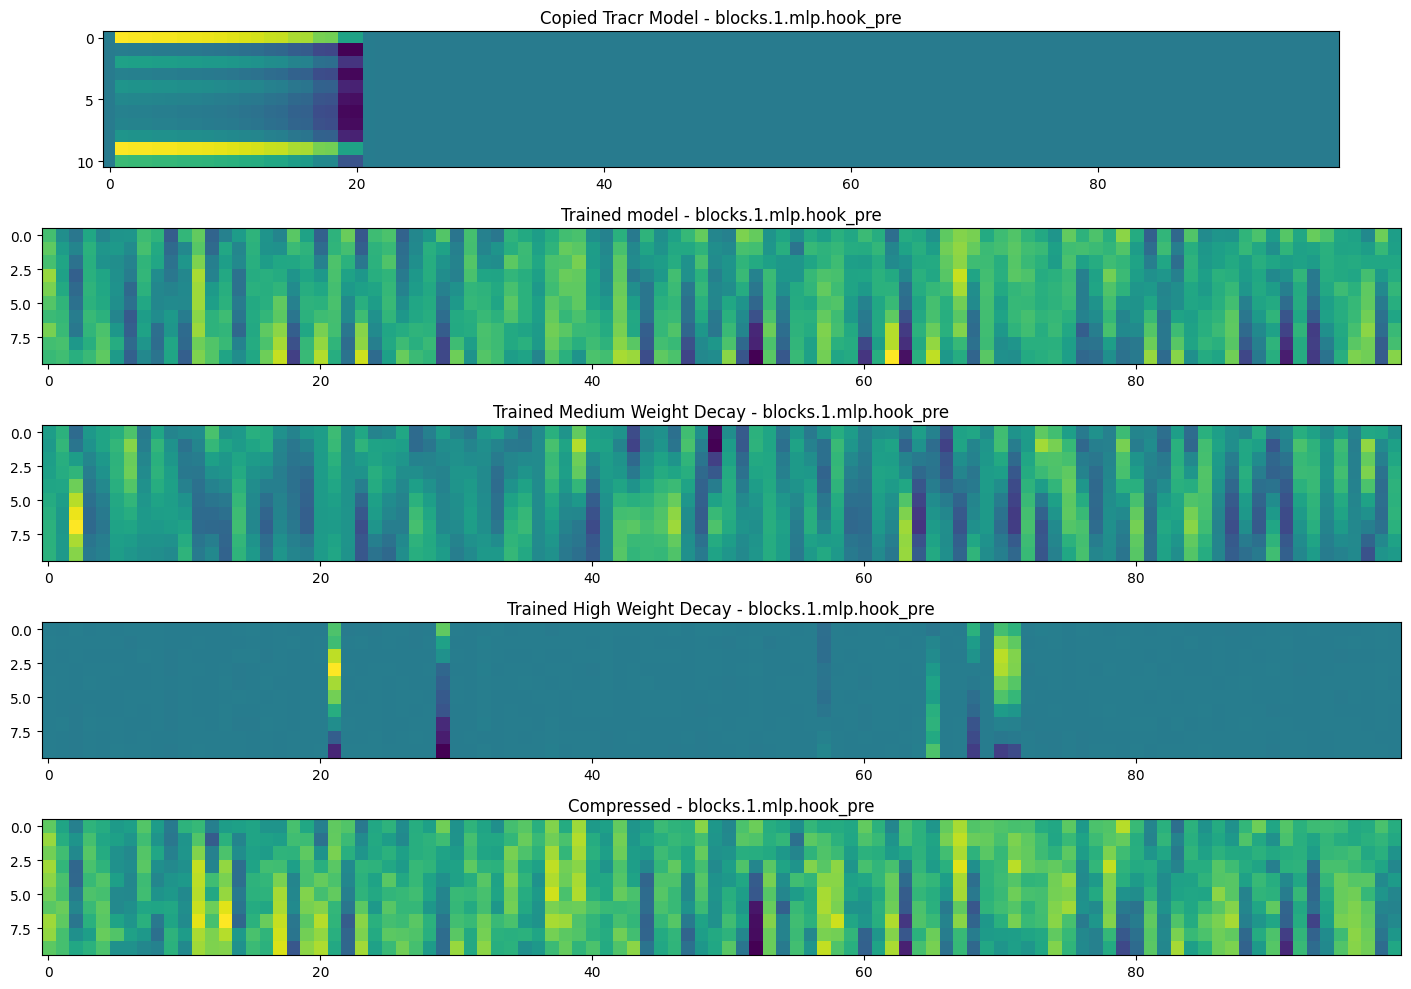

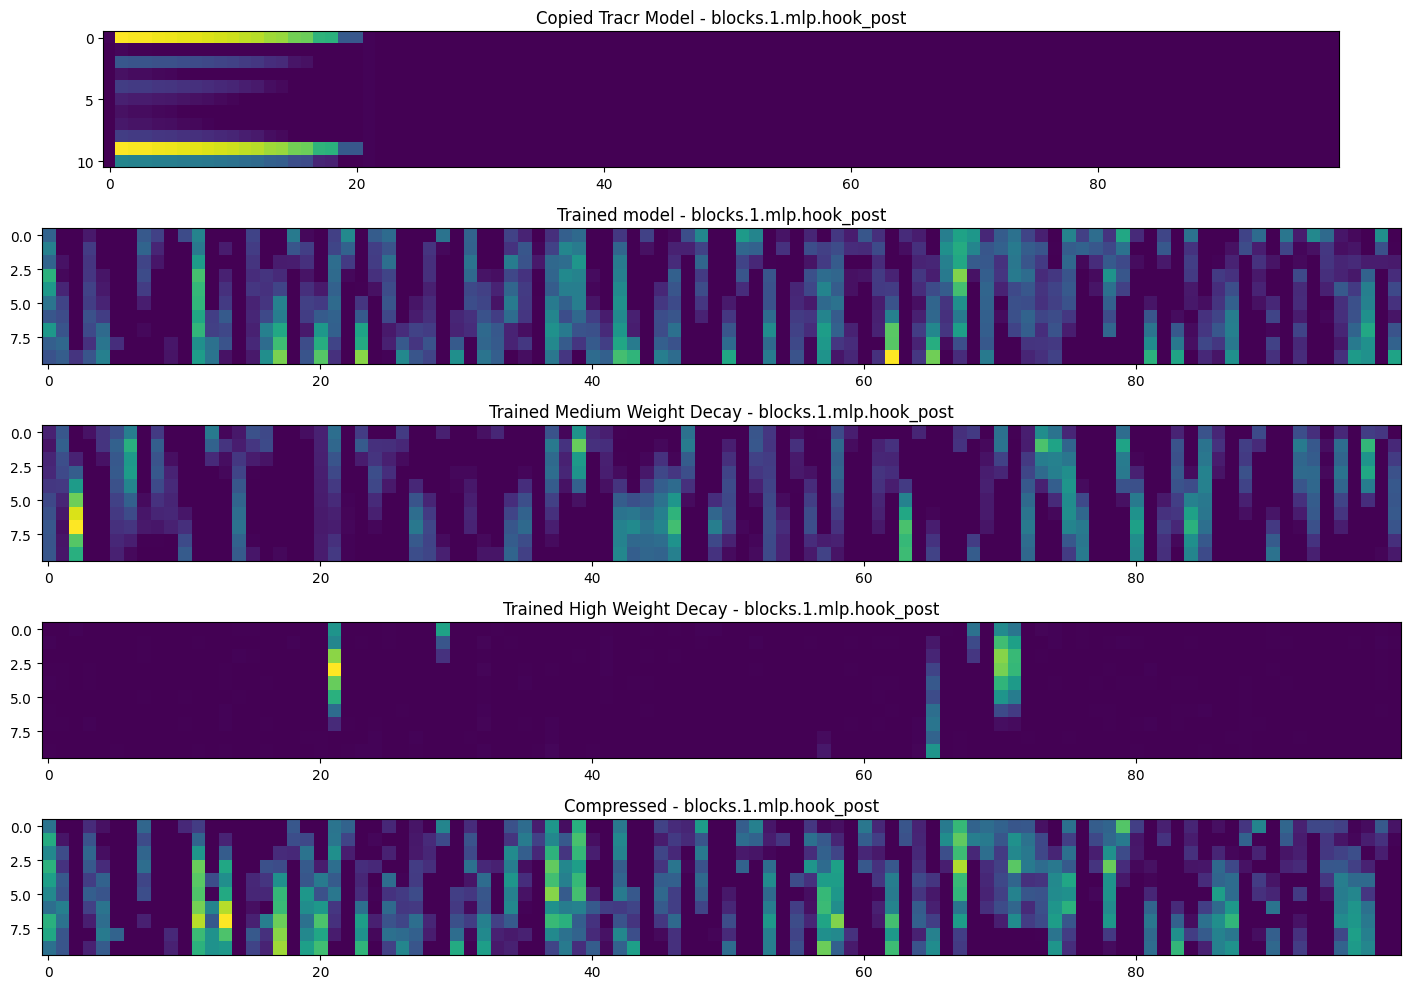

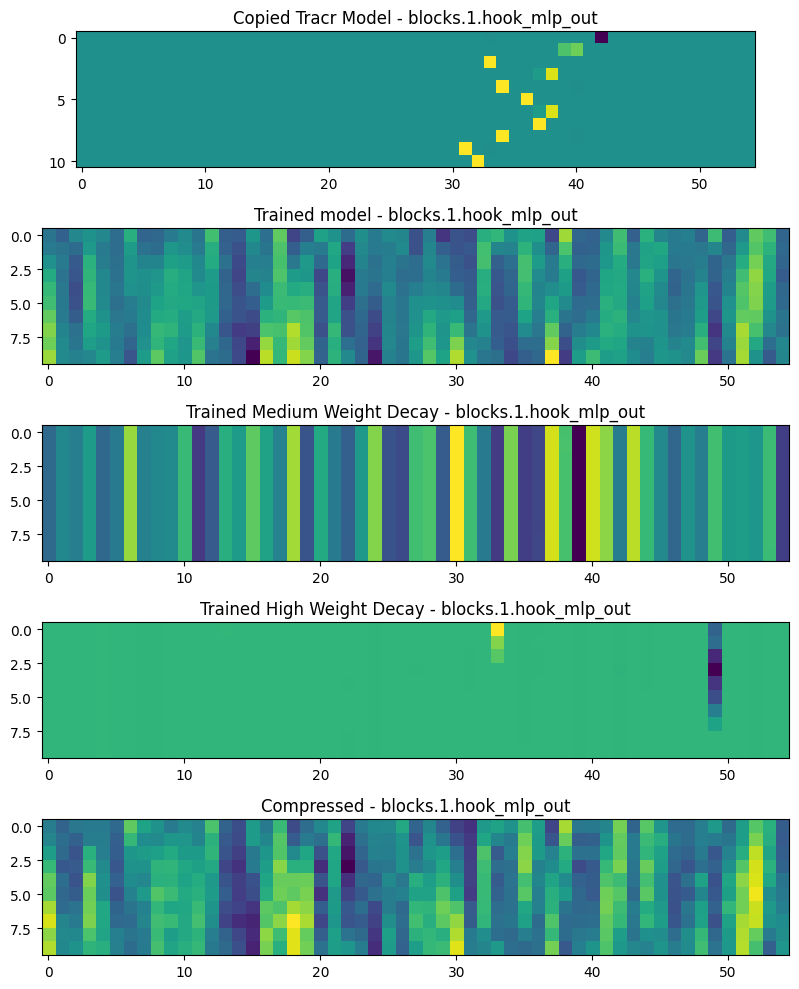

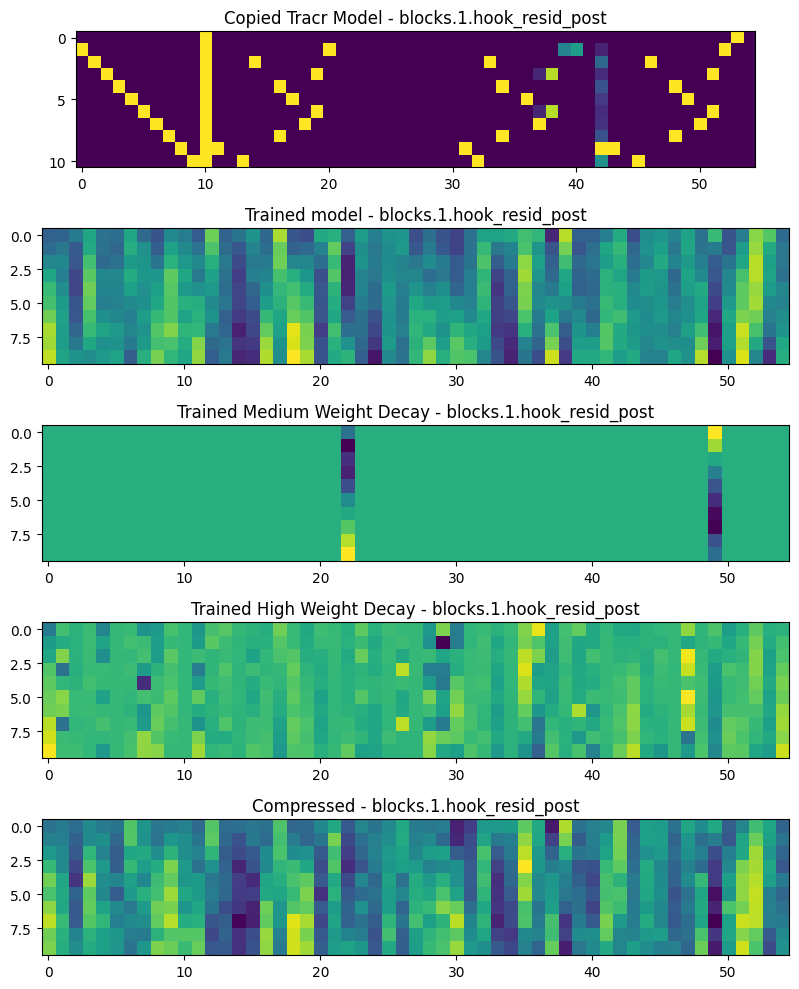

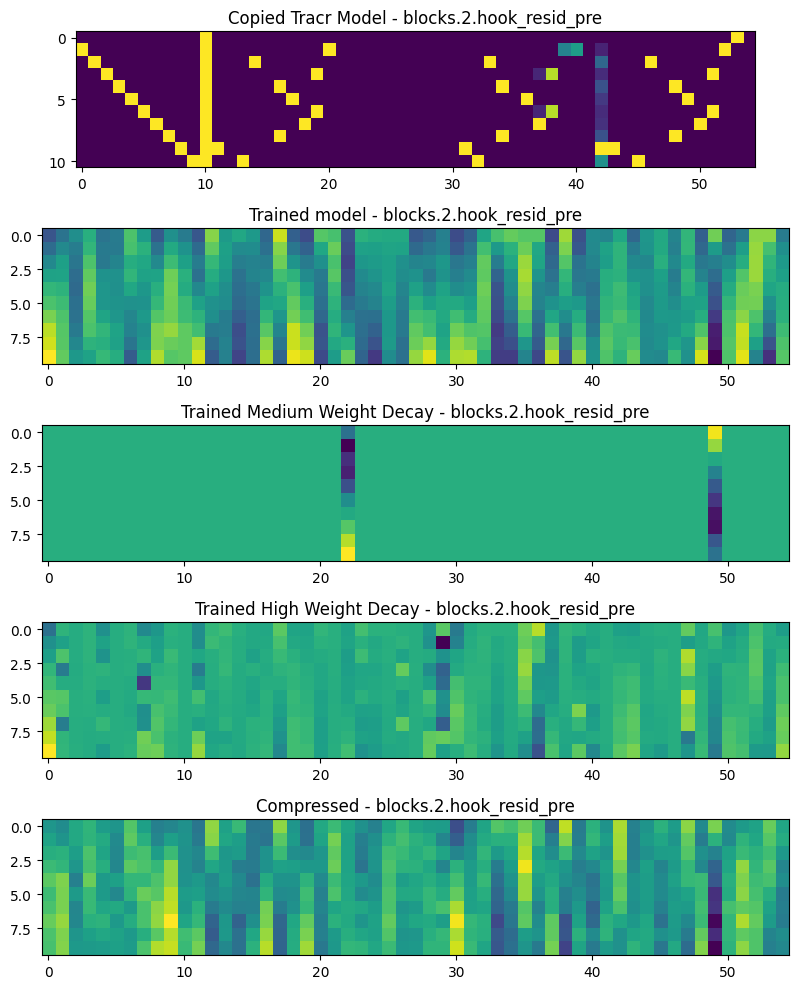

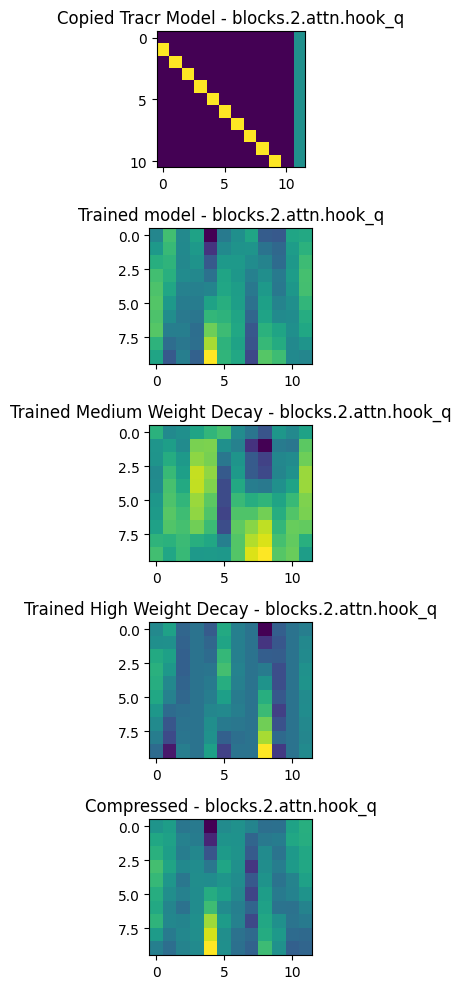

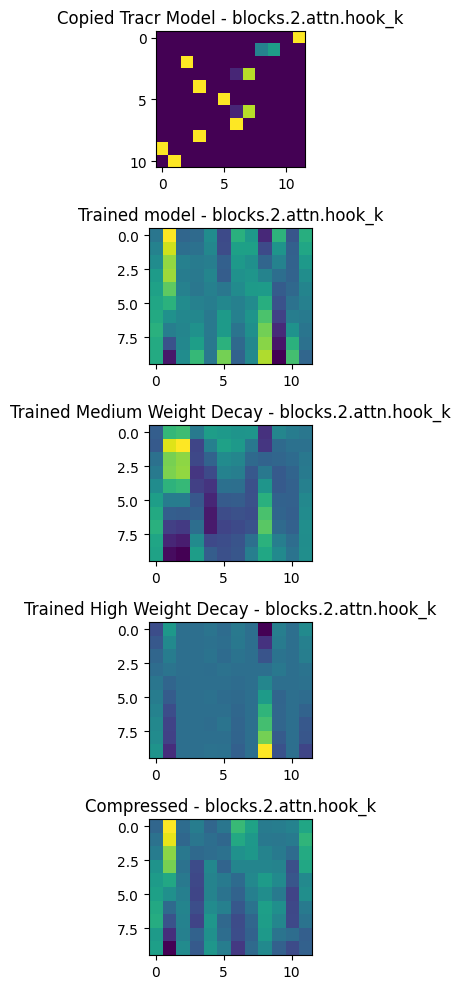

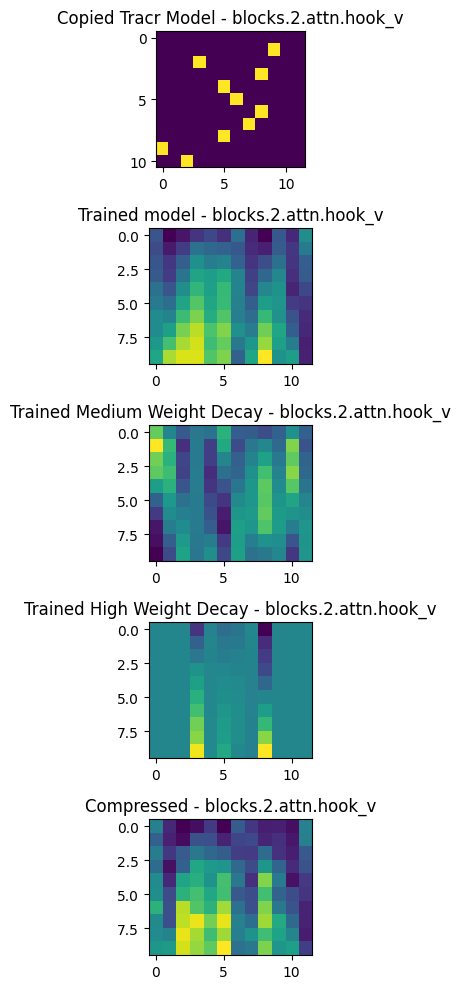

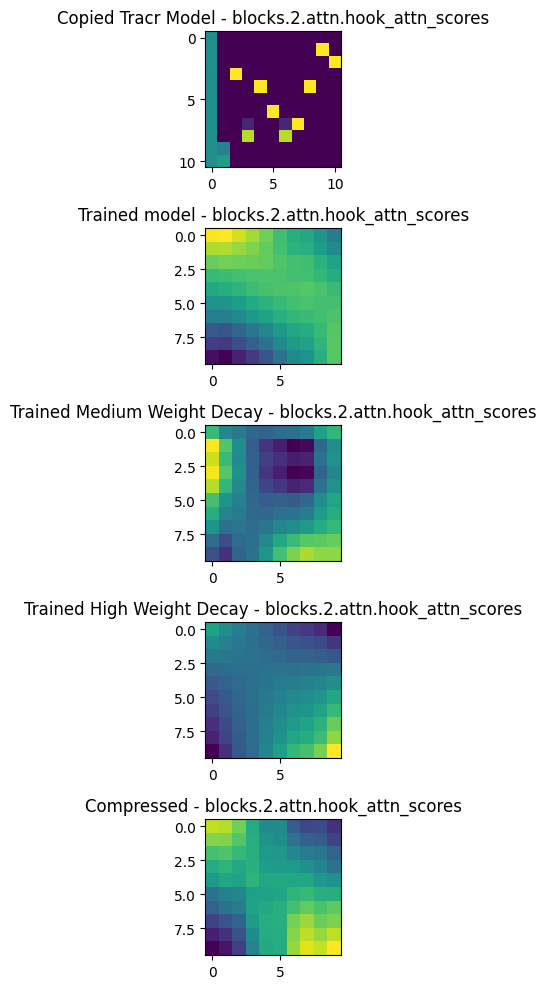

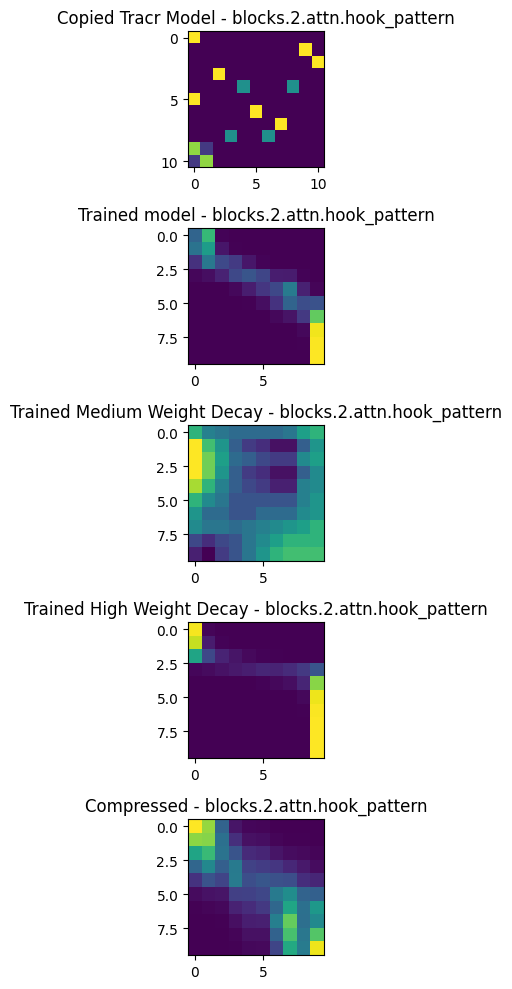

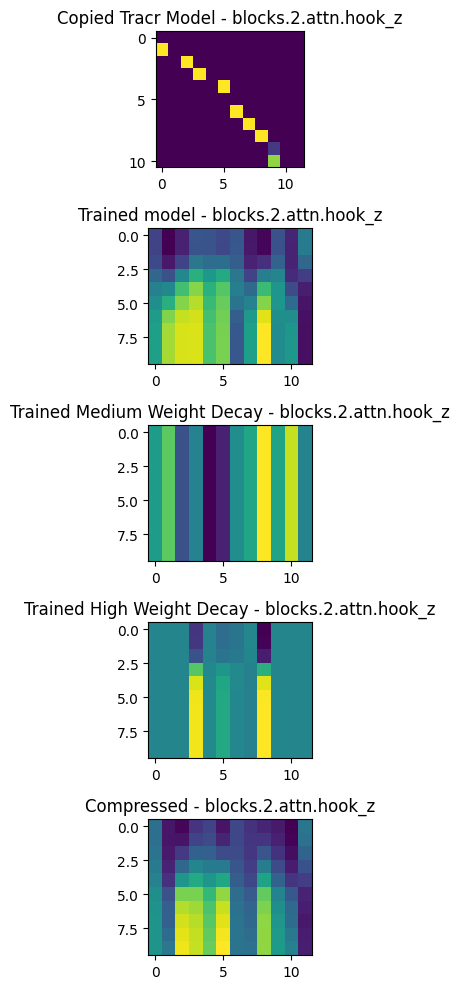

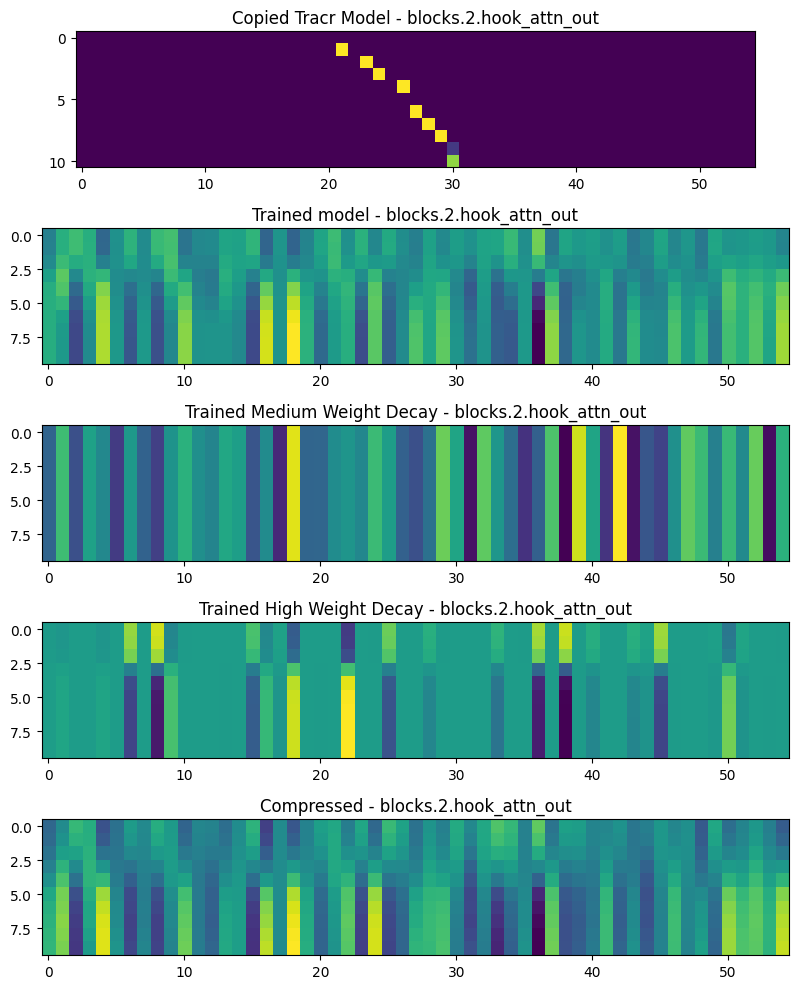

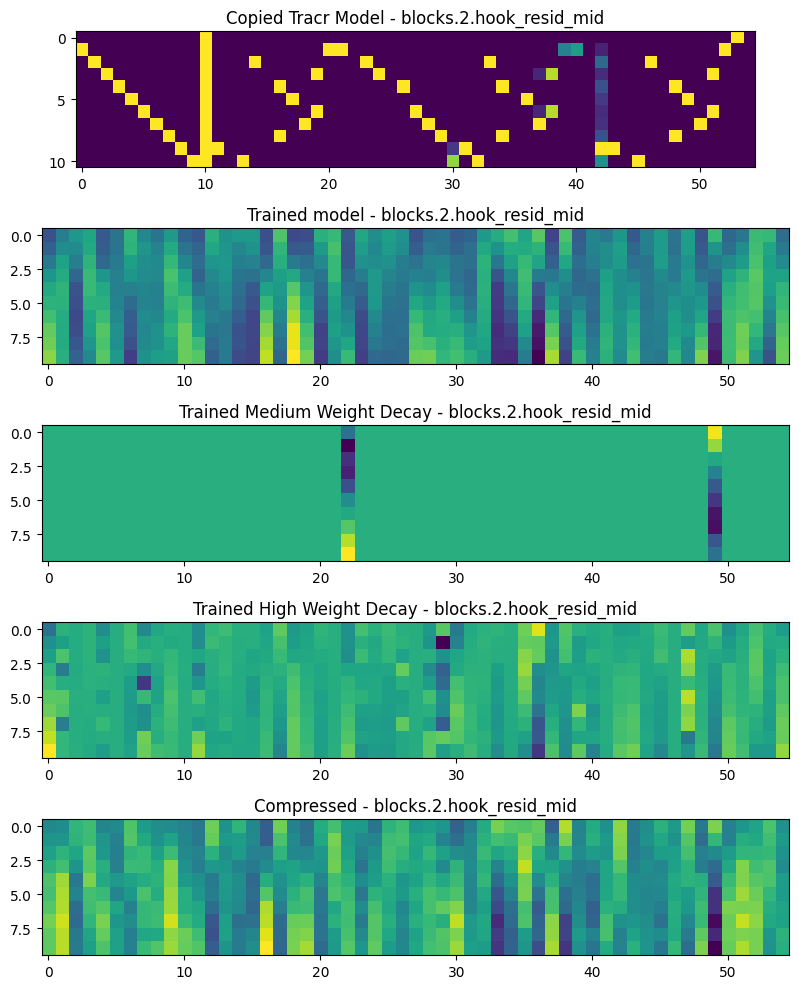

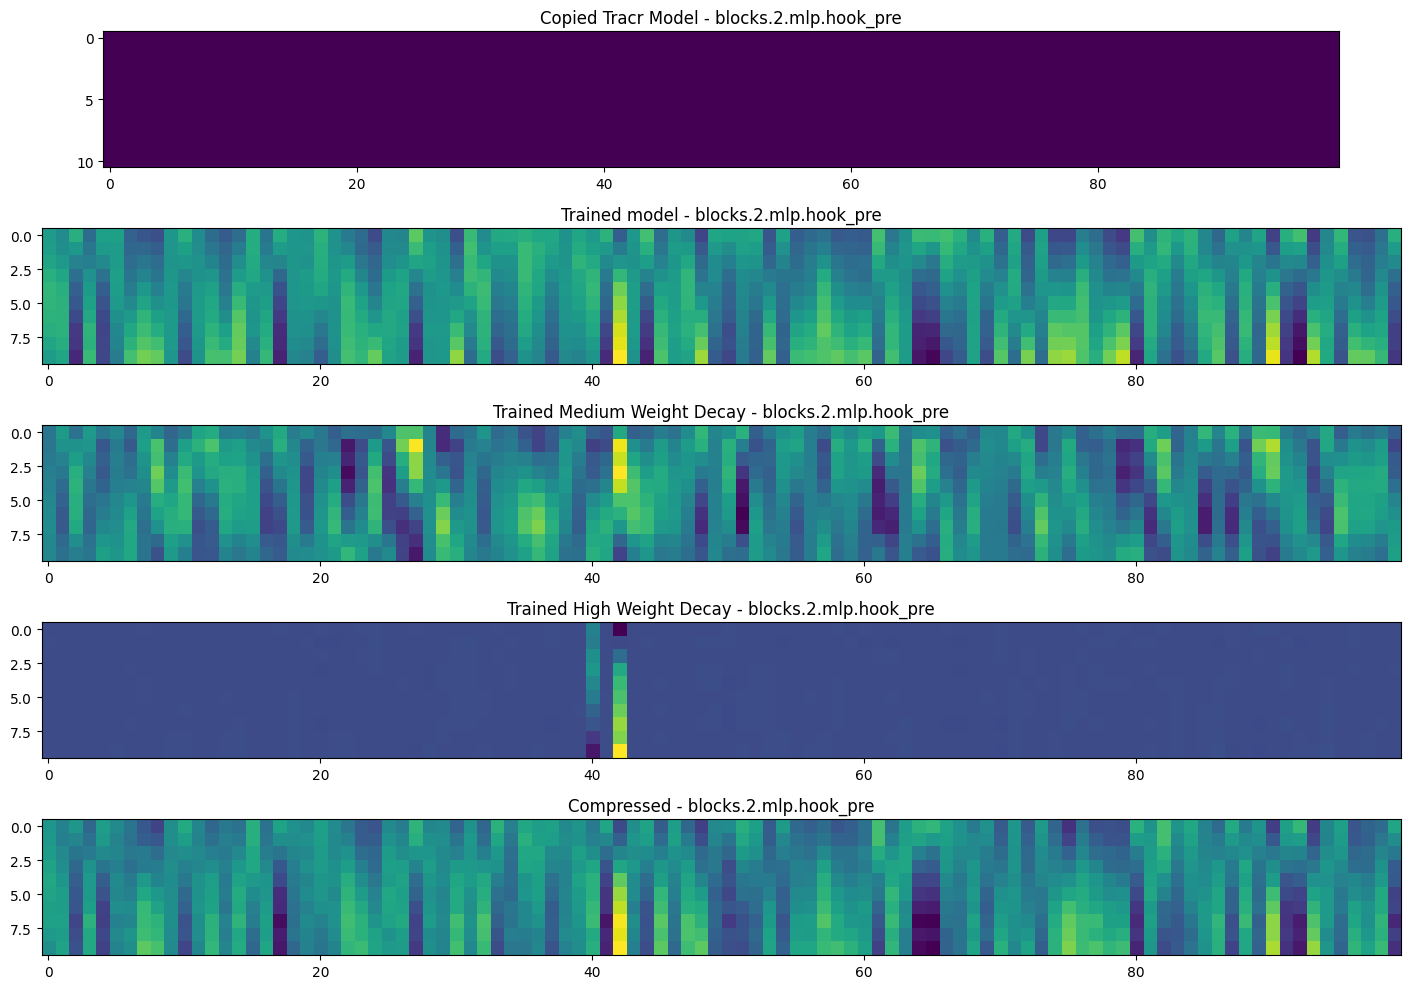

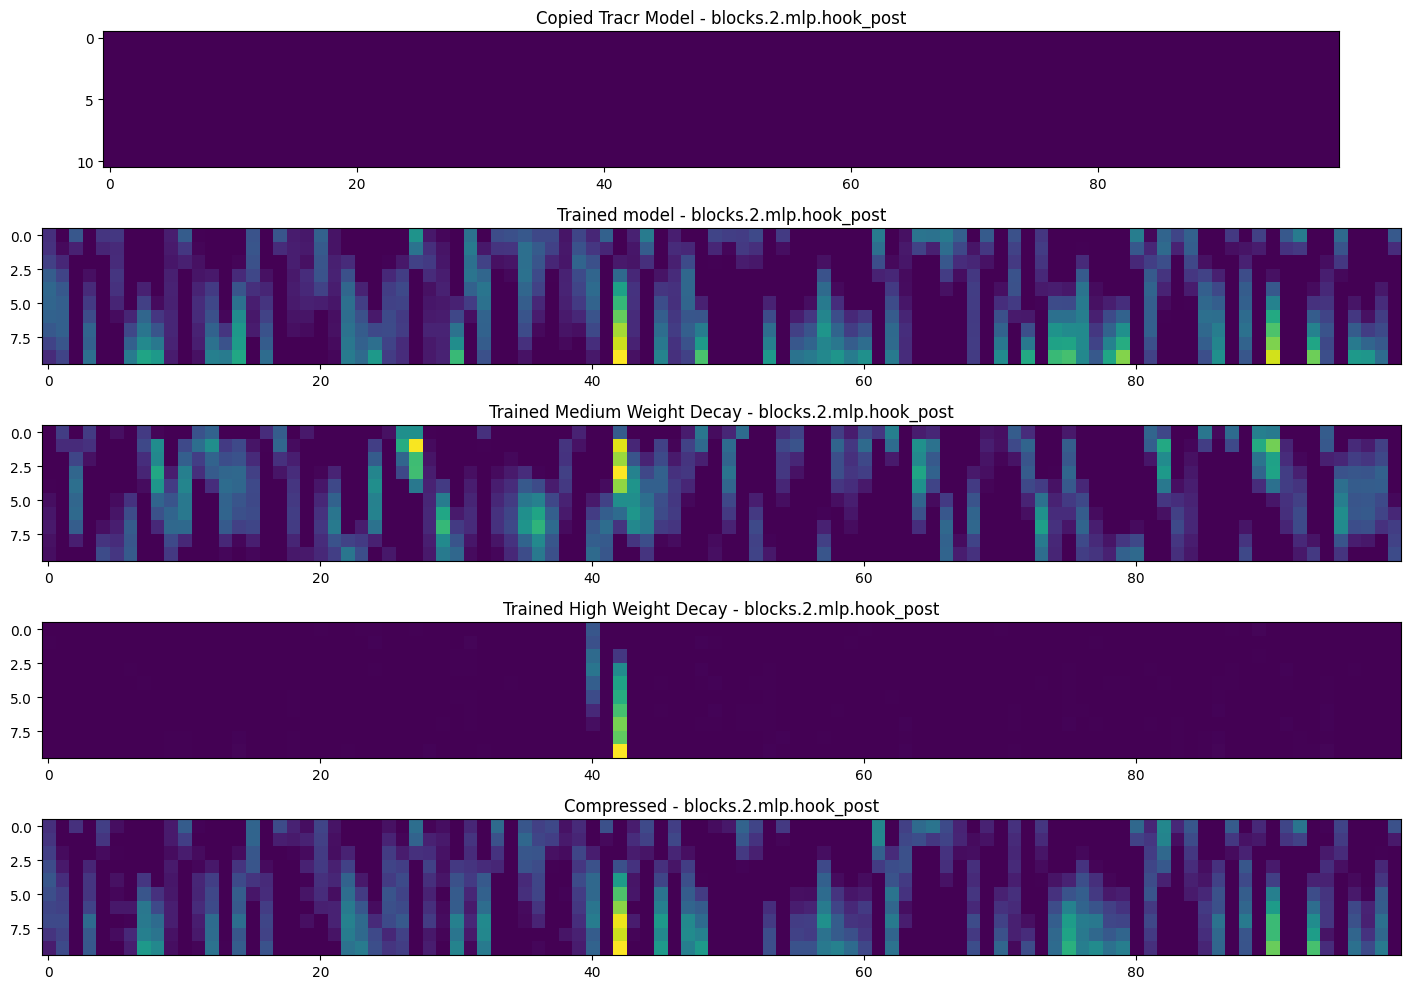

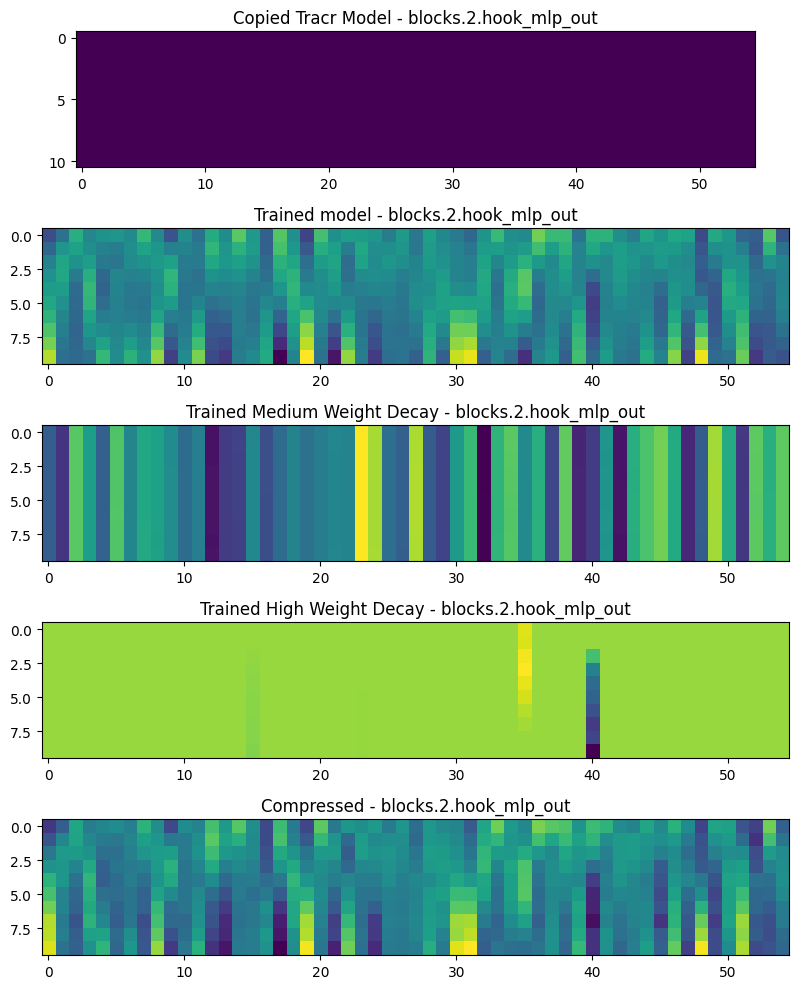

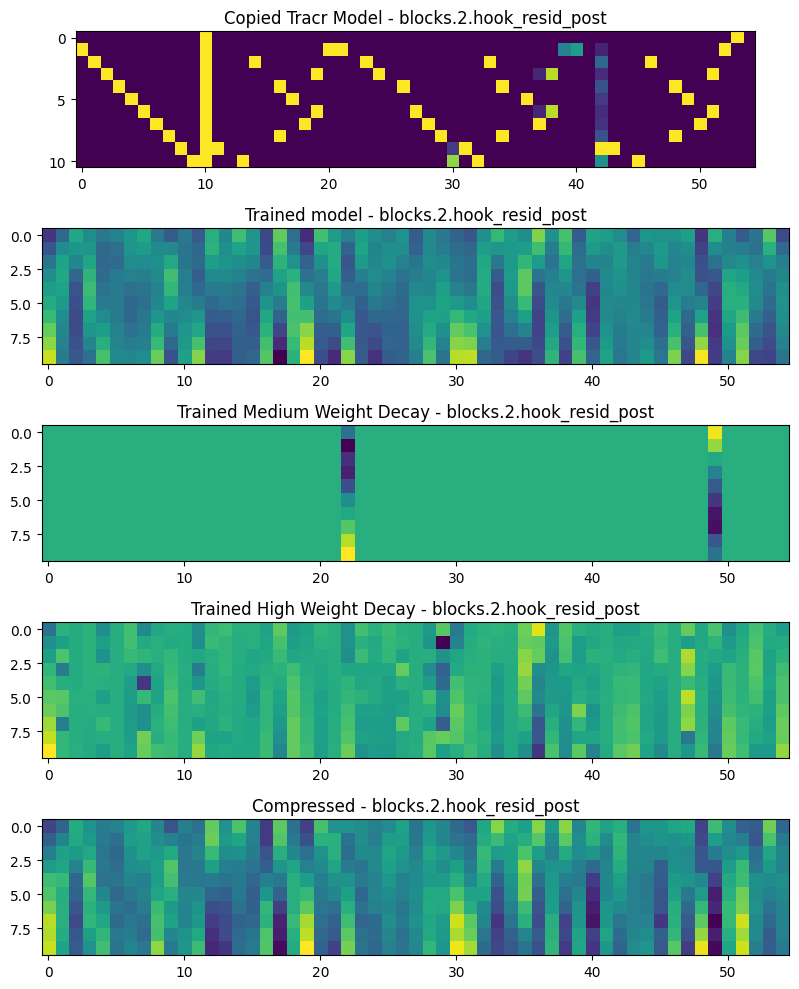

In [70]:
reload_fuctions()
act_caches = [cache.items() for cache in [tracr_cache, trained_cache, trained_mid_decay_cache, trained_high_decay_cache, compressed_cache]]
act_zipped = [*zip(*act_caches)][2:]
labels = ["Copied Tracr Model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay", "Compressed"]

for i, activations in enumerate(act_zipped):
    plot_activations(
        [f"{labels[i]} - {activations[i][0]}" for i in range(len(activations))],
        *[to_numpy(activation[1]) for activation in activations]
    )


# Questions
- What would be useful hypothesis to test?
- How do I relate the trained model to the tracr model when they are so different?
- As for compressing the model, would this be as simple as changing d_model?
- Since the model only has one layer, there are no intermediate steps to investigate. Should my investigation be fully on the attention heads and mlp layers?
- 


## plan of attack
- Regularize models
- Get nnsight to work, potentially using hugging face
- Compress models